<img src="https://raw.githubusercontent.com/imedinam50/MCDI/main/MCDI.jpg">

<div style="text-align: right"> <H1> Procesamiento de Información  </H1></div>
<br><br><br>
<div style="text-align: right"> <H2> Profesor. Dr. Sabino Miranda Jiménez </H2></div>
<div style="text-align: right"> <H2> Profesor. Dr. Dagoberto Armenta Medina </H2></div>
<br><br>

<H2><B> Unidad 8. Desempeño de los clasificadores </B></H2>
<br><br>
<H3><I> Ismael Medina Muñoz </I></H3>
<div style="text-align: right"> Fecha de entrega: 2021-06-03 </div>

---

# Actividad 1. Clasificación de información
## Introducción

El ejercicio propuesto es evaluar el desempeño de dos clasificadores vistos en el bloque anterior: Naive Bayes y Support Vector Machine (lineal).

Se usarán los preprocesamientos del ejercicio anterior, CounterVectorizer y TFIDFVectorizer para el pesado, a fin de evaluar los clasificadores propuestos.

Una vez entrenado cada modelo, se predecirán los datos para el conjunto test que se proporciona: datos de agresividad (2 clases) y datos de celulares (4 clases).

El reporte contiene el código de la creación de los modelos, así como la evaluación de  los desempeños de cada combinación, es decir, el clasificador, los distintos pesados y para los dos conjuntos de datos:

* Mostrar la matriz de confusión. 
* El cálculo de la precisión, recall, F-score  para macro y micro para cada configuración del clasificador y conjunto de datos
* Comparación los datos de evaluación de cada configuración

## Desarrollo

Primero definiremos las funciones para abrir los archivos JSON con los que trabajaremos en el resto del ejercicio con comentarios de twitter donde el objetivo es un celular y algunas marcas en específico.

In [1]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer  
from nltk.stem import SnowballStemmer
import pandas as pd
import json
import unicodedata
import numpy as np
import matplotlib.pyplot as plt

En el siguiente código se aplican los procesamientos como uso de sólo minúsculas, eliminar puntuación, eliminar stopwords, usar unigramas, y usar stemming.

In [2]:
PUNCTUACTION = ";:,.\\-\"'/"
SYMBOLS = "()[]¿?¡!{}~<>|"
SKIP_SYMBOLS = set(PUNCTUACTION + SYMBOLS)
SKIP_SYMBOLS_AND_SPACES = set(PUNCTUACTION + SYMBOLS + '\t\n\r ')

def normalize_text(input_str,
                   punct=False,
                   accents=False,
                   stemming=True,
                   stopwords=False,
                   max_dup=2):
    
    ##cachedStopWords = [unidecode.unidecode(token) for token in stopwords.words('spanish')] 
    
    stemmer=SnowballStemmer("spanish")
    ## Uso de minusculas
    nfkd_f = unicodedata.normalize('NFKD', input_str.lower())
    n_str = []
    c_prev = ''
    cc_prev = 0
    for c in nfkd_f:
        ## Elimina puntuación
        if not punct:
            if c in SKIP_SYMBOLS:
                continue
        if not accents and unicodedata.combining(c):
            continue
        if c_prev == c:
            cc_prev += 1
            if cc_prev >= max_dup:
                continue
        else:
            cc_prev = 0
        n_str.append(c)
        c_prev = c
        
    n_str = "".join(n_str)
    
    if stemming:
        tokens = n_str.split()
        stemmed_tokens = [stemmer.stem(token) for token in tokens]
        n_str = ' '.join(stemmed_tokens)

    return n_str

def line_iterator(filename):
    if filename.endswith(".gz"):
        f = gzip.GzipFile(filename)
    else:
        f = open(filename, encoding='utf8')

    while True:
        line = f.readline()
        # Test the type of the line and encode it if neccesary...
        if type(line) is bytes:
            line = str(line, encoding='utf8')

        # If the line is empty, we are done...
        if len(line) == 0:
            break

        line = line.strip()
        # If line is empty, jump to next...
        if len(line) == 0:
            continue

        yield line

    # Close the file...
    f.close()

def tweet_iterator(filename):
    for line in line_iterator(filename):
        yield json.loads(line)

### Preparando los datos para el entrenamiento de modelos

In [3]:
def load_corpus(file):
    X=[]
    Y=[]
    for review in tweet_iterator(file):
        text = normalize_text(review['text'])
        X.append(text.lower())
        Y.append(review['klass'])
    return X,Y

In [4]:
X_CP, Y_CP = load_corpus("cellphones_train.json")
X_CP_gold,Y_CP_gold = load_corpus("cellphones_test.json")

X_AD, Y_AD = load_corpus("AggressivenessDetection_train.json")
X_AD_gold,Y_AD_gold = load_corpus("AggressivenessDetection_test.json")

In [5]:
# Source code for plotting confusion matrix is based on `plot_confusion_matrix` 
# via https://runawayhorse001.github.io/LearningApacheSpark/classification.html#decision-tree-classification
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_CP_confusion_matrix(cm, title):
    # Clear Plot
    plt.gcf().clear()
    plt.rcParams["figure.figsize"] = 8, 8

    # Configure figure
    fig = plt.figure(1)

    # Configure plot
    classes = ['information', 'negative', 'neutral', 'positive']
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Normalize and establish threshold
    normalize=False
    fmt = 'd'
    thresh = cm.max() / 2.

    # Iterate through the confusion matrix cells
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    # Final plot configurations
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

    # Display images
    image = fig

    # Show plot
    fig = plt.show()

    # Save plot
    #fig.savefig("confusion-matrix.png")

    # Display Plot
    ##display(image)

    # Close Plot
    ##plt.close(fig)

def plot_AD_confusion_matrix(cm, title):
    # Clear Plot
    plt.gcf().clear()
    plt.rcParams["figure.figsize"] = 8, 8

    # Configure figure
    fig = plt.figure(1)

    # Configure plot
    classes = ['0', '1']
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Normalize and establish threshold
    normalize=False
    fmt = 'd'
    thresh = cm.max() / 2.

    # Iterate through the confusion matrix cells
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    # Final plot configurations
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

    # Display images
    image = fig

    # Show plot
    fig = plt.show()

    # Save plot
    #fig.savefig("confusion-matrix.png")

    # Display Plot
    ##display(image)

    # Close Plot
    ##plt.close(fig)    

In [6]:
import pandas as pd

valores = [('Accuracy', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
           ('macro F1', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
           ('micro F1', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
           ('macro Precision', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
           ('micro Precision', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
           ('macro Recall', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
           ('micro Recall', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)]

dfTabla = pd.DataFrame(valores,
                     columns=['Medida', 
                              'CellPhone_Train_TF_Naive', 'CellPhone_Test_TF_Naive', 
                              'CellPhone_Train_TFIDF_Naive', 'CellPhone_Test_TFIDF_Naive', 
                              'CellPhone_Train_TF_SVM', 'CellPhone_Test_TF_SVM', 
                              'CellPhone_Train_TFIDF_SVM', 'CellPhone_Test_TFIDF_SVM', 
                              'Aggressiveness_Train_TF_Naive', 'Aggressiveness_Test_TF_Naive', 
                              'Aggressiveness_Train_TFIDF_Naive', 'Aggressiveness_Test_TFIDF_Naive', 
                              'Aggressiveness_Train_TF_SVM', 'Aggressiveness_Test_TF_SVM', 
                              'Aggressiveness_Train_TFIDF_SVM', 'Aggressiveness_Test_TFIDF_SVM'])

dfTabla = dfTabla.set_index(dfTabla['Medida'])

### Entrenamiento de modelos - Modelos bayesianos para datos de celulares

#### En las siguientes celdas entrenaremos el modelo usando $TF$

In [7]:
vectorizer = CountVectorizer(stop_words=stopwords.words('spanish'))  
X_CP_vec = vectorizer.fit_transform(X_CP)

In [8]:
from sklearn.naive_bayes import MultinomialNB
mnb_CP = MultinomialNB()
mnb_CP.fit(X_CP_vec, Y_CP)

MultinomialNB()

Ahora evaluaremos el modelo

In [9]:
X_CP_vec = vectorizer.transform(X_CP)
mnb_CP_predict = mnb_CP.predict(X_CP_vec)

Aquí obtendremos las métricas de desempeño sobre el conjunto de entrenamiento

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("TRAIN - Accuracy MB =", accuracy_score(Y_CP, mnb_CP_predict))

print("TRAIN - F1 MB =", f1_score(Y_CP, mnb_CP_predict, average='macro'))
print("TRAIN - micro F1 MB =", f1_score(Y_CP, mnb_CP_predict, average='micro'))

print("TRAIN - Precision MB =", precision_score(Y_CP, mnb_CP_predict, average='macro'))
print("TRAIN - micro Precision MB =", precision_score(Y_CP, mnb_CP_predict, average='micro'))

print("TRAIN - Recall MB =", recall_score(Y_CP, mnb_CP_predict, average='macro'))
print("TRAIN - micro Recall MB =", recall_score(Y_CP, mnb_CP_predict, average='micro'))

dfTabla.at['Accuracy', 'CellPhone_Train_TF_Naive'] = accuracy_score(Y_CP, mnb_CP_predict)
dfTabla.at['macro F1', 'CellPhone_Train_TF_Naive'] = f1_score(Y_CP, mnb_CP_predict, average='macro')
dfTabla.at['micro F1', 'CellPhone_Train_TF_Naive'] = f1_score(Y_CP, mnb_CP_predict, average='micro')
dfTabla.at['macro Precision', 'CellPhone_Train_TF_Naive'] = precision_score(Y_CP, mnb_CP_predict, average='macro')
dfTabla.at['micro Precision', 'CellPhone_Train_TF_Naive'] = precision_score(Y_CP, mnb_CP_predict, average='micro')
dfTabla.at['macro Recall', 'CellPhone_Train_TF_Naive'] = recall_score(Y_CP, mnb_CP_predict, average='macro')
dfTabla.at['micro Recall', 'CellPhone_Train_TF_Naive'] = recall_score(Y_CP, mnb_CP_predict, average='micro')

TRAIN - Accuracy MB = 0.8252359314924852
TRAIN - F1 MB = 0.7027265495314776
TRAIN - micro F1 MB = 0.8252359314924852
TRAIN - Precision MB = 0.8390581060557862
TRAIN - micro Precision MB = 0.8252359314924852
TRAIN - Recall MB = 0.6376626531409484
TRAIN - micro Recall MB = 0.8252359314924852


Para mejor visualización, se anexa la gráfica de la matríz de confunsión.

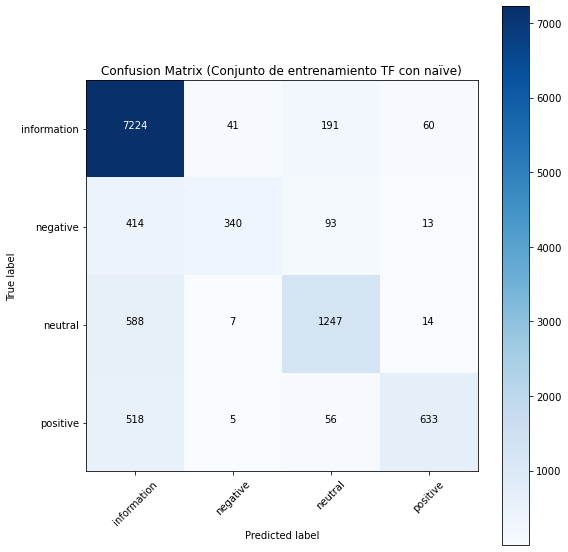

In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_CP, mnb_CP_predict, labels=['information', 'negative', 'neutral', 'positive'])

plot_CP_confusion_matrix(cm, "Confusion Matrix (Conjunto de entrenamiento TF con naïve)")

Vamos a hacer las predicciones con el modelo entrenado y las gráficas de conteos

In [13]:
X_new_vec = vectorizer.transform(X_CP_gold)
new_predict = mnb_CP.predict(X_new_vec)

In [14]:
X_pred = pd.DataFrame(list(zip(X_CP_gold, new_predict)), columns=['text', 'klass'])
X_pred.groupby(['klass']).size()

klass
information    4193
negative         64
neutral         475
positive        173
dtype: int64

In [15]:
print("TEST - Accuracy MB =", accuracy_score(Y_CP_gold, new_predict))

print("TEST - F1 MB =", f1_score(Y_CP_gold, new_predict, average='macro'))
print("TEST - micro F1 MB =", f1_score(Y_CP_gold, new_predict, average='micro'))

print("TEST - Precision MB =", precision_score(Y_CP_gold, new_predict, average='macro'))
print("TEST - micro Precision MB =", precision_score(Y_CP_gold, new_predict, average='micro'))

print("TEST - Recall MB =", recall_score(Y_CP_gold, new_predict, average='macro'))
print("TEST - micro Recall MB =", recall_score(Y_CP_gold, new_predict, average='micro'))

dfTabla.at['Accuracy', 'CellPhone_Test_TF_Naive'] = accuracy_score(Y_CP_gold, new_predict)
dfTabla.at['macro F1', 'CellPhone_Test_TF_Naive'] = f1_score(Y_CP_gold, new_predict, average='macro')
dfTabla.at['micro F1', 'CellPhone_Test_TF_Naive'] = f1_score(Y_CP_gold, new_predict, average='micro')
dfTabla.at['macro Precision', 'CellPhone_Test_TF_Naive'] = precision_score(Y_CP_gold, new_predict, average='macro')
dfTabla.at['micro Precision', 'CellPhone_Test_TF_Naive'] = precision_score(Y_CP_gold, new_predict, average='micro')
dfTabla.at['macro Recall', 'CellPhone_Test_TF_Naive'] = recall_score(Y_CP_gold, new_predict, average='macro')
dfTabla.at['micro Recall', 'CellPhone_Test_TF_Naive'] = recall_score(Y_CP_gold, new_predict, average='micro')

TEST - Accuracy MB = 0.7286442405708461
TEST - F1 MB = 0.4782348528416201
TEST - micro F1 MB = 0.7286442405708461
TEST - Precision MB = 0.722005768991752
TEST - micro Precision MB = 0.7286442405708461
TEST - Recall MB = 0.43088600079014994
TEST - micro Recall MB = 0.7286442405708461


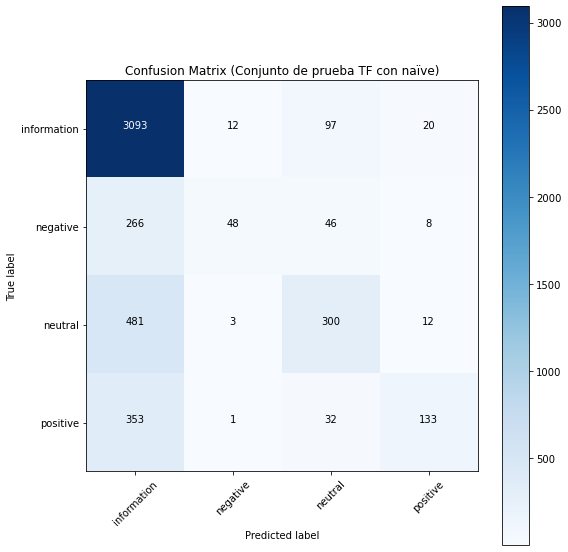

In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_CP_gold, new_predict, labels=['information', 'negative', 'neutral', 'positive'])

plot_CP_confusion_matrix(cm, "Confusion Matrix (Conjunto de prueba TF con naïve)")

#### En las siguientes celdas entrenaremos el modelo usando $TF-IDF$

In [17]:
tfidfvec = TfidfVectorizer(stop_words=stopwords.words('spanish'))  
X_CP_vec = tfidfvec.fit_transform(X_CP)

In [18]:
from sklearn.naive_bayes import MultinomialNB
mnb_CP = MultinomialNB()
mnb_CP.fit(X_CP_vec, Y_CP)

MultinomialNB()

Ahora evaluaremos el modelo

In [19]:
X_CP_vec = tfidfvec.transform(X_CP)
mnb_CP_predict = mnb_CP.predict(X_CP_vec)

Aquí obtendremos las métricas de desempeño sobre el conjunto de entrenamiento

In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("TRAIN - Accuracy MB =", accuracy_score(Y_CP, mnb_CP_predict))

print("TRAIN - F1 MB =", f1_score(Y_CP, mnb_CP_predict, average='macro'))
print("TRAIN - micro F1 MB =", f1_score(Y_CP, mnb_CP_predict, average='micro'))

print("TRAIN - Precision MB =", precision_score(Y_CP, mnb_CP_predict, average='macro'))
print("TRAIN - micro Precision MB =", precision_score(Y_CP, mnb_CP_predict, average='micro'))

print("TRAIN - Recall MB =", recall_score(Y_CP, mnb_CP_predict, average='macro'))
print("TRAIN - micro Recall MB =", recall_score(Y_CP, mnb_CP_predict, average='micro'))

dfTabla.at['Accuracy', 'CellPhone_Train_TFIDF_Naive'] = accuracy_score(Y_CP, mnb_CP_predict)
dfTabla.at['macro F1', 'CellPhone_Train_TFIDF_Naive'] = f1_score(Y_CP, mnb_CP_predict, average='macro')
dfTabla.at['micro F1', 'CellPhone_Train_TFIDF_Naive'] = f1_score(Y_CP, mnb_CP_predict, average='micro')
dfTabla.at['macro Precision', 'CellPhone_Train_TFIDF_Naive'] = precision_score(Y_CP, mnb_CP_predict, average='macro')
dfTabla.at['micro Precision', 'CellPhone_Train_TFIDF_Naive'] = precision_score(Y_CP, mnb_CP_predict, average='micro')
dfTabla.at['macro Recall', 'CellPhone_Train_TFIDF_Naive'] = recall_score(Y_CP, mnb_CP_predict, average='macro')
dfTabla.at['micro Recall', 'CellPhone_Train_TFIDF_Naive'] = recall_score(Y_CP, mnb_CP_predict, average='micro')

TRAIN - Accuracy MB = 0.7164452988465572
TRAIN - F1 MB = 0.39397089613813274
TRAIN - micro F1 MB = 0.7164452988465572
TRAIN - Precision MB = 0.9152217613714762
TRAIN - micro Precision MB = 0.7164452988465572
TRAIN - Recall MB = 0.362435424695718
TRAIN - micro Recall MB = 0.7164452988465572


Para mejor visualización, se anexa la gráfica de la matríz de confunsión.

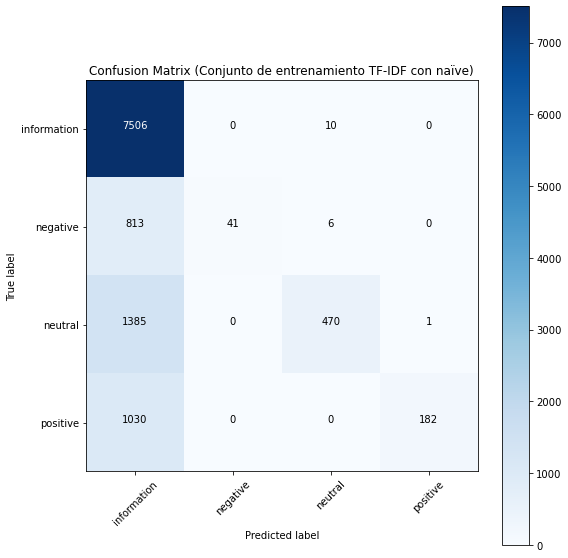

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_CP, mnb_CP_predict, labels=['information', 'negative', 'neutral', 'positive'])

plot_CP_confusion_matrix(cm, "Confusion Matrix (Conjunto de entrenamiento TF-IDF con naïve)")

Vamos a hacer las predicciones con el modelo entrenado y las gráficas de conteos

In [22]:
X_new_vec = tfidfvec.transform(X_CP_gold)
new_predict = mnb_CP.predict(X_new_vec)

In [23]:
X_pred = pd.DataFrame(list(zip(X_CP_gold, new_predict)), columns=['text', 'klass'])
X_pred.groupby(['klass']).size()

klass
information    4646
negative          8
neutral         178
positive         73
dtype: int64

In [24]:
print("TEST - Accuracy MB =", accuracy_score(Y_CP_gold, new_predict))

print("TEST - F1 MB =", f1_score(Y_CP_gold, new_predict, average='macro'))
print("TEST - micro F1 MB =", f1_score(Y_CP_gold, new_predict, average='micro'))

print("TEST - Precision MB =", precision_score(Y_CP_gold, new_predict, average='macro'))
print("TEST - micro Precision MB =", precision_score(Y_CP_gold, new_predict, average='micro'))

print("TEST - Recall MB =", recall_score(Y_CP_gold, new_predict, average='macro'))
print("TEST - micro Recall MB =", recall_score(Y_CP_gold, new_predict, average='micro'))

dfTabla.at['Accuracy', 'CellPhone_Test_TFIDF_Naive'] = accuracy_score(Y_CP_gold, new_predict)
dfTabla.at['macro F1', 'CellPhone_Test_TFIDF_Naive'] = f1_score(Y_CP_gold, new_predict, average='macro')
dfTabla.at['micro F1', 'CellPhone_Test_TFIDF_Naive'] = f1_score(Y_CP_gold, new_predict, average='micro')
dfTabla.at['macro Precision', 'CellPhone_Test_TFIDF_Naive'] = precision_score(Y_CP_gold, new_predict, average='macro')
dfTabla.at['micro Precision', 'CellPhone_Test_TFIDF_Naive'] = precision_score(Y_CP_gold, new_predict, average='micro')
dfTabla.at['macro Recall', 'CellPhone_Test_TFIDF_Naive'] = recall_score(Y_CP_gold, new_predict, average='macro')
dfTabla.at['micro Recall', 'CellPhone_Test_TFIDF_Naive'] = recall_score(Y_CP_gold, new_predict, average='micro')

TEST - Accuracy MB = 0.7078491335372069
TEST - F1 MB = 0.3656019756027303
TEST - micro F1 MB = 0.7078491335372069
TEST - Precision MB = 0.916137235364963
TEST - micro Precision MB = 0.7078491335372069
TEST - Recall MB = 0.3446223637240693
TEST - micro Recall MB = 0.7078491335372069


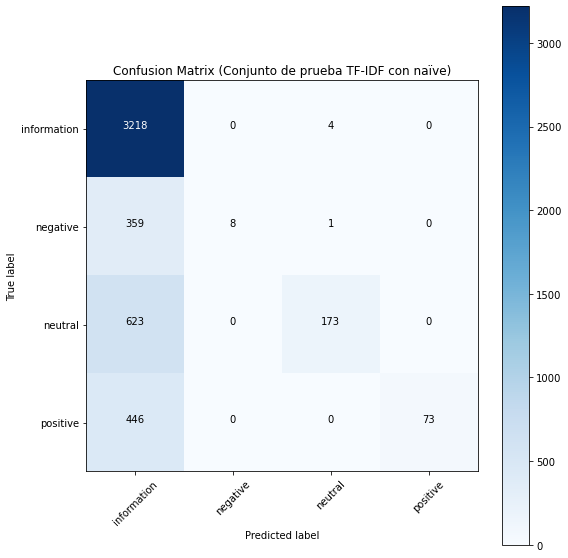

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_CP_gold, new_predict, labels=['information', 'negative', 'neutral', 'positive'])

plot_CP_confusion_matrix(cm, "Confusion Matrix (Conjunto de prueba TF-IDF con naïve)")

### Entrenamiento de modelos - Modelos bayesianos para detección de agresividad

#### En las siguientes celdas entrenaremos el modelo usando $TF$

In [26]:
vectorizer = CountVectorizer(stop_words=stopwords.words('spanish'))  
X_AD_vec = vectorizer.fit_transform(X_AD)

In [27]:
from sklearn.naive_bayes import MultinomialNB
mnb_AD = MultinomialNB()
mnb_AD.fit(X_AD_vec, Y_AD)

MultinomialNB()

Ahora evaluaremos el modelo

In [28]:
X_AD_vec = vectorizer.transform(X_AD)
mnb_AD_predict = mnb_AD.predict(X_AD_vec)

Aquí obtendremos las métricas de desempeño sobre el conjunto de entrenamiento

In [29]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("TRAIN - Accuracy MB =", accuracy_score(Y_AD, mnb_AD_predict))

print("TRAIN - F1 MB =", f1_score(Y_AD, mnb_AD_predict, average='macro'))
print("TRAIN - micro F1 MB =", f1_score(Y_AD, mnb_AD_predict, average='micro'))

print("TRAIN - Precision MB =", precision_score(Y_AD, mnb_AD_predict, average='macro'))
print("TRAIN - micro Precision MB =", precision_score(Y_AD, mnb_AD_predict, average='micro'))

print("TRAIN - Recall MB =", recall_score(Y_AD, mnb_AD_predict, average='macro'))
print("TRAIN - micro Recall MB =", recall_score(Y_AD, mnb_AD_predict, average='micro'))

dfTabla.at['Accuracy', 'Aggressiveness_Train_TF_Naive'] = accuracy_score(Y_AD, mnb_AD_predict)
dfTabla.at['macro F1', 'Aggressiveness_Train_TF_Naive'] = f1_score(Y_AD, mnb_AD_predict, average='macro')
dfTabla.at['micro F1', 'Aggressiveness_Train_TF_Naive'] = f1_score(Y_AD, mnb_AD_predict, average='micro')
dfTabla.at['macro Precision', 'Aggressiveness_Train_TF_Naive'] = precision_score(Y_AD, mnb_AD_predict, average='macro')
dfTabla.at['micro Precision', 'Aggressiveness_Train_TF_Naive'] = precision_score(Y_AD, mnb_AD_predict, average='micro')
dfTabla.at['macro Recall', 'Aggressiveness_Train_TF_Naive'] = recall_score(Y_AD, mnb_AD_predict, average='macro')
dfTabla.at['micro Recall', 'Aggressiveness_Train_TF_Naive'] = recall_score(Y_AD, mnb_AD_predict, average='micro')

TRAIN - Accuracy MB = 0.9204988308651598
TRAIN - F1 MB = 0.898387028207255
TRAIN - micro F1 MB = 0.9204988308651598
TRAIN - Precision MB = 0.9216353080747854
TRAIN - micro Precision MB = 0.9204988308651598
TRAIN - Recall MB = 0.8812478060771316
TRAIN - micro Recall MB = 0.9204988308651598


Para mejor visualización, se anexa la gráfica de la matríz de confunsión.

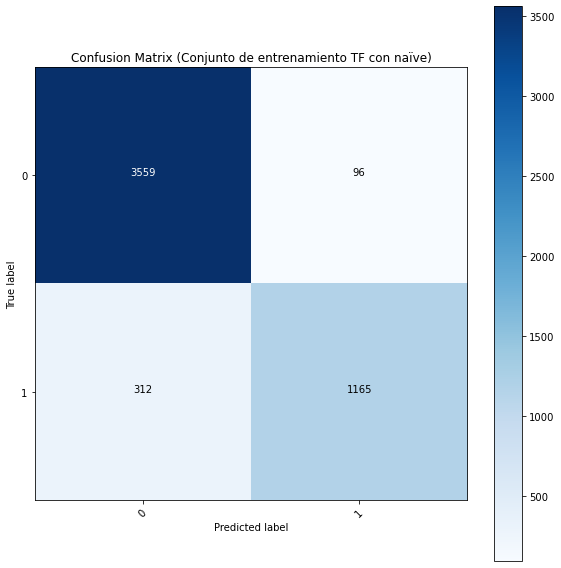

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_AD, mnb_AD_predict, labels=[0, 1])

plot_AD_confusion_matrix(cm, "Confusion Matrix (Conjunto de entrenamiento TF con naïve)")

Vamos a hacer las predicciones con el modelo entrenado y las gráficas de conteos

In [31]:
X_new_vec = vectorizer.transform(X_AD_gold)
new_predict = mnb_AD.predict(X_new_vec)

In [32]:
X_pred = pd.DataFrame(list(zip(X_AD_gold, new_predict)), columns=['text', 'klass'])
X_pred.groupby(['klass']).size()

klass
0    1753
1     443
dtype: int64

In [33]:
print("TEST - Accuracy MB =", accuracy_score(Y_AD_gold, new_predict))

print("TEST - F1 MB =", f1_score(Y_AD_gold, new_predict, average='macro'))
print("TEST - micro F1 MB =", f1_score(Y_AD_gold, new_predict, average='micro'))

print("TEST - Precision MB =", precision_score(Y_AD_gold, new_predict, average='macro'))
print("TEST - micro Precision MB =", precision_score(Y_AD_gold, new_predict, average='micro'))

print("TEST - Recall MB =", recall_score(Y_AD_gold, new_predict, average='macro'))
print("TEST - micro Recall MB =", recall_score(Y_AD_gold, new_predict, average='micro'))

dfTabla.at['Accuracy', 'Aggressiveness_Test_TF_Naive'] = accuracy_score(Y_AD_gold, new_predict)
dfTabla.at['macro F1', 'Aggressiveness_Test_TF_Naive'] = f1_score(Y_AD_gold, new_predict, average='macro')
dfTabla.at['micro F1', 'Aggressiveness_Test_TF_Naive'] = f1_score(Y_AD_gold, new_predict, average='micro')
dfTabla.at['macro Precision', 'Aggressiveness_Test_TF_Naive'] = precision_score(Y_AD_gold, new_predict, average='macro')
dfTabla.at['micro Precision', 'Aggressiveness_Test_TF_Naive'] = precision_score(Y_AD_gold, new_predict, average='micro')
dfTabla.at['macro Recall', 'Aggressiveness_Test_TF_Naive'] = recall_score(Y_AD_gold, new_predict, average='macro')
dfTabla.at['micro Recall', 'Aggressiveness_Test_TF_Naive'] = recall_score(Y_AD_gold, new_predict, average='micro')

TEST - Accuracy MB = 0.8169398907103825
TEST - F1 MB = 0.7522705001666886
TEST - micro F1 MB = 0.8169398907103824
TEST - Precision MB = 0.7950910338806483
TEST - micro Precision MB = 0.8169398907103825
TEST - Recall MB = 0.7320587535379209
TEST - micro Recall MB = 0.8169398907103825


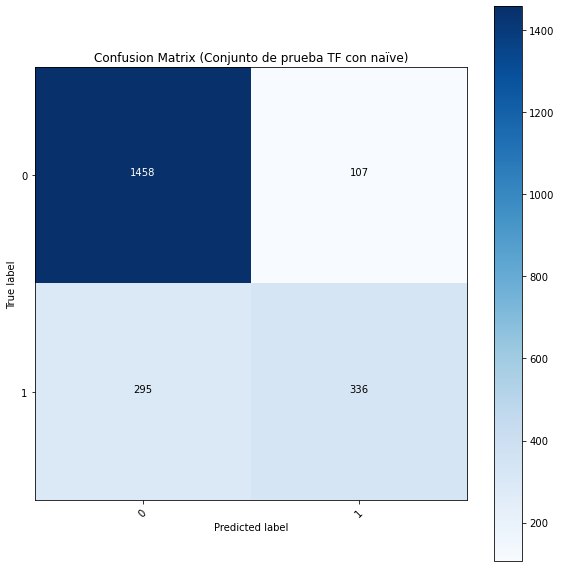

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_AD_gold, new_predict, labels=[0, 1])

plot_AD_confusion_matrix(cm, "Confusion Matrix (Conjunto de prueba TF con naïve)")

#### En las siguientes celdas entrenaremos el modelo usando $TF-IDF$

In [35]:
tfidfvec = TfidfVectorizer(stop_words=stopwords.words('spanish'))  
X_AD_vec = tfidfvec.fit_transform(X_AD)

In [36]:
from sklearn.naive_bayes import MultinomialNB
mnb_AD = MultinomialNB()
mnb_AD.fit(X_AD_vec, Y_AD)

MultinomialNB()

Ahora evaluaremos el modelo

In [37]:
X_AD_vec = tfidfvec.transform(X_AD)
mnb_AD_predict = mnb_AD.predict(X_AD_vec)

Aquí obtendremos las métricas de desempeño sobre el conjunto de entrenamiento

In [38]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("TRAIN - Accuracy MB =", accuracy_score(Y_AD, mnb_AD_predict))

print("TRAIN - F1 MB =", f1_score(Y_AD, mnb_AD_predict, average='macro'))
print("TRAIN - micro F1 MB =", f1_score(Y_AD, mnb_AD_predict, average='micro'))

print("TRAIN - Precision MB =", precision_score(Y_AD, mnb_AD_predict, average='macro'))
print("TRAIN - micro Precision MB =", precision_score(Y_AD, mnb_AD_predict, average='micro'))

print("TRAIN - Recall MB =", recall_score(Y_AD, mnb_AD_predict, average='macro'))
print("TRAIN - micro Recall MB =", recall_score(Y_AD, mnb_AD_predict, average='micro'))

dfTabla.at['Accuracy', 'Aggressiveness_Train_TFIDF_Naive'] = accuracy_score(Y_AD, mnb_AD_predict)
dfTabla.at['macro F1', 'Aggressiveness_Train_TFIDF_Naive'] = f1_score(Y_AD, mnb_AD_predict, average='macro')
dfTabla.at['micro F1', 'Aggressiveness_Train_TFIDF_Naive'] = f1_score(Y_AD, mnb_AD_predict, average='micro')
dfTabla.at['macro Precision', 'Aggressiveness_Train_TFIDF_Naive'] = precision_score(Y_AD, mnb_AD_predict, average='macro')
dfTabla.at['micro Precision', 'Aggressiveness_Train_TFIDF_Naive'] = precision_score(Y_AD, mnb_AD_predict, average='micro')
dfTabla.at['macro Recall', 'Aggressiveness_Train_TFIDF_Naive'] = recall_score(Y_AD, mnb_AD_predict, average='macro')
dfTabla.at['micro Recall', 'Aggressiveness_Train_TFIDF_Naive'] = recall_score(Y_AD, mnb_AD_predict, average='micro')

TRAIN - Accuracy MB = 0.8176149649259548
TRAIN - F1 MB = 0.712833727416726
TRAIN - micro F1 MB = 0.8176149649259548
TRAIN - Precision MB = 0.8922080043775478
TRAIN - micro Precision MB = 0.8176149649259548
TRAIN - Recall MB = 0.6845535789539006
TRAIN - micro Recall MB = 0.8176149649259548


Para mejor visualización, se anexa la gráfica de la matríz de confunsión.

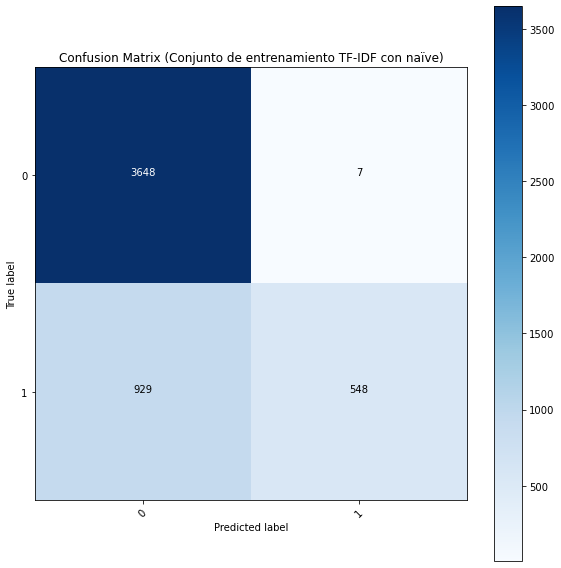

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_AD, mnb_AD_predict, labels=[0, 1])

plot_AD_confusion_matrix(cm, "Confusion Matrix (Conjunto de entrenamiento TF-IDF con naïve)")

Vamos a hacer las predicciones con el modelo entrenado y las gráficas de conteos

In [40]:
X_new_vec = tfidfvec.transform(X_AD_gold)
new_predict = mnb_AD.predict(X_new_vec)

In [41]:
X_pred = pd.DataFrame(list(zip(X_AD_gold, new_predict)), columns=['text', 'klass'])
X_pred.groupby(['klass']).size()

klass
0    2102
1      94
dtype: int64

In [42]:
print("TEST - Accuracy MB =", accuracy_score(Y_AD_gold, new_predict))

print("TEST - F1 MB =", f1_score(Y_AD_gold, new_predict, average='macro'))
print("TEST - micro F1 MB =", f1_score(Y_AD_gold, new_predict, average='micro'))

print("TEST - Precision MB =", precision_score(Y_AD_gold, new_predict, average='macro'))
print("TEST - micro Precision MB =", precision_score(Y_AD_gold, new_predict, average='micro'))

print("TEST - Recall MB =", recall_score(Y_AD_gold, new_predict, average='macro'))
print("TEST - micro Recall MB =", recall_score(Y_AD_gold, new_predict, average='micro'))

dfTabla.at['Accuracy', 'Aggressiveness_Test_TFIDF_Naive'] = accuracy_score(Y_AD_gold, new_predict)
dfTabla.at['macro F1', 'Aggressiveness_Test_TFIDF_Naive'] = f1_score(Y_AD_gold, new_predict, average='macro')
dfTabla.at['micro F1', 'Aggressiveness_Test_TFIDF_Naive'] = f1_score(Y_AD_gold, new_predict, average='micro')
dfTabla.at['macro Precision', 'Aggressiveness_Test_TFIDF_Naive'] = precision_score(Y_AD_gold, new_predict, average='macro')
dfTabla.at['micro Precision', 'Aggressiveness_Test_TFIDF_Naive'] = precision_score(Y_AD_gold, new_predict, average='micro')
dfTabla.at['macro Recall', 'Aggressiveness_Test_TFIDF_Naive'] = recall_score(Y_AD_gold, new_predict, average='macro')
dfTabla.at['micro Recall', 'Aggressiveness_Test_TFIDF_Naive'] = recall_score(Y_AD_gold, new_predict, average='micro')

TEST - Accuracy MB = 0.7481785063752276
TEST - F1 MB = 0.5432184534948233
TEST - micro F1 MB = 0.7481785063752278
TEST - Precision MB = 0.8278083689292872
TEST - micro Precision MB = 0.7481785063752276
TEST - Recall MB = 0.5655898897738263
TEST - micro Recall MB = 0.7481785063752276


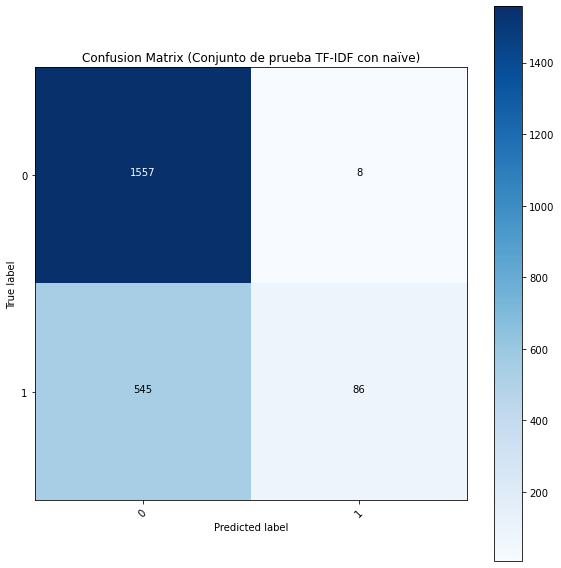

In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_AD_gold, new_predict, labels=[0, 1])

plot_AD_confusion_matrix(cm, "Confusion Matrix (Conjunto de prueba TF-IDF con naïve)")

### Entrenamiento de modelos - Modelos SVM para datos de celulares

#### En las siguientes celdas entrenaremos el modelo usando $TF$

In [44]:
vectorizer = CountVectorizer(stop_words=stopwords.words('spanish'))  
X_CP_vec = vectorizer.fit_transform(X_CP)

In [45]:
from sklearn.svm import LinearSVC
svc_CP = LinearSVC(random_state=0, max_iter=3000)
svc_CP.fit(X_CP_vec, Y_CP)

LinearSVC(max_iter=3000, random_state=0)

Ahora evaluaremos el modelo

In [46]:
X_CP_vec = vectorizer.transform(X_CP)
svc_CP_predict = svc_CP.predict(X_CP_vec)

Aquí obtendremos las métricas de desempeño sobre el conjunto de entrenamiento

In [47]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("TRAIN - Accuracy SVM =", accuracy_score(Y_CP, svc_CP_predict))

print("TRAIN - F1 SVM =", f1_score(Y_CP, svc_CP_predict, average='macro'))
print("TRAIN - micro F1 SVM =", f1_score(Y_CP, svc_CP_predict, average='micro'))

print("TRAIN - Precision SVM =", precision_score(Y_CP, svc_CP_predict, average='macro'))
print("TRAIN - micro Precision SVM =", precision_score(Y_CP, svc_CP_predict, average='micro'))

print("TRAIN - Recall SVM =", recall_score(Y_CP, svc_CP_predict, average='macro'))
print("TRAIN - micro Recall SVM =", recall_score(Y_CP, svc_CP_predict, average='micro'))

dfTabla.at['Accuracy', 'CellPhone_Train_TF_SVM'] = accuracy_score(Y_CP, svc_CP_predict)
dfTabla.at['macro F1', 'CellPhone_Train_TF_SVM'] = f1_score(Y_CP, svc_CP_predict, average='macro')
dfTabla.at['micro F1', 'CellPhone_Train_TF_SVM'] = f1_score(Y_CP, svc_CP_predict, average='micro')
dfTabla.at['macro Precision', 'CellPhone_Train_TF_SVM'] = precision_score(Y_CP, svc_CP_predict, average='macro')
dfTabla.at['micro Precision', 'CellPhone_Train_TF_SVM'] = precision_score(Y_CP, svc_CP_predict, average='micro')
dfTabla.at['macro Recall', 'CellPhone_Train_TF_SVM'] = recall_score(Y_CP, svc_CP_predict, average='macro')
dfTabla.at['micro Recall', 'CellPhone_Train_TF_SVM'] = recall_score(Y_CP, svc_CP_predict, average='micro')

TRAIN - Accuracy SVM = 0.9848829080741
TRAIN - F1 SVM = 0.9770146207807215
TRAIN - micro F1 SVM = 0.9848829080741
TRAIN - Precision SVM = 0.9801063462118231
TRAIN - micro Precision SVM = 0.9848829080741
TRAIN - Recall SVM = 0.9739950087027499
TRAIN - micro Recall SVM = 0.9848829080741


Para mejor visualización, se anexa la gráfica de la matríz de confunsión.

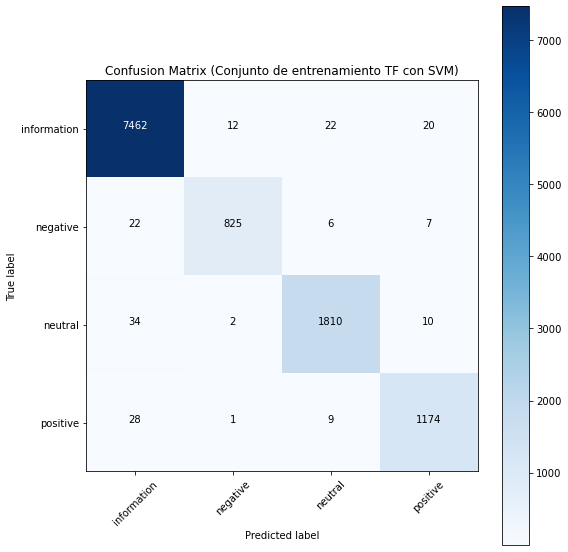

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_CP, svc_CP_predict, labels=['information', 'negative', 'neutral', 'positive'])

plot_CP_confusion_matrix(cm, "Confusion Matrix (Conjunto de entrenamiento TF con SVM)")

Vamos a hacer las predicciones con el modelo entrenado y las gráficas de conteos

In [49]:
X_new_vec = vectorizer.transform(X_CP_gold)
new_predict = svc_CP.predict(X_new_vec)

In [50]:
X_pred = pd.DataFrame(list(zip(X_CP_gold, new_predict)), columns=['text', 'klass'])
X_pred.groupby(['klass']).size()

klass
information    3324
negative        333
neutral         745
positive        503
dtype: int64

In [51]:
print("TEST - Accuracy SVM =", accuracy_score(Y_CP_gold, new_predict))

print("TEST - F1 SVM =", f1_score(Y_CP_gold, new_predict, average='macro'))
print("TEST - micro F1 SVM =", f1_score(Y_CP_gold, new_predict, average='micro'))

print("TEST - Precision SVM =", precision_score(Y_CP_gold, new_predict, average='macro'))
print("TEST - micro Precision SVM =", precision_score(Y_CP_gold, new_predict, average='micro'))

print("TEST - Recall SVM =", recall_score(Y_CP_gold, new_predict, average='macro'))
print("TEST - micro Recall SVM =", recall_score(Y_CP_gold, new_predict, average='micro'))

dfTabla.at['Accuracy', 'CellPhone_Test_TF_SVM'] = accuracy_score(Y_CP_gold, new_predict)
dfTabla.at['macro F1', 'CellPhone_Test_TF_SVM'] = f1_score(Y_CP_gold, new_predict, average='macro')
dfTabla.at['micro F1', 'CellPhone_Test_TF_SVM'] = f1_score(Y_CP_gold, new_predict, average='micro')
dfTabla.at['macro Precision', 'CellPhone_Test_TF_SVM'] = precision_score(Y_CP_gold, new_predict, average='macro')
dfTabla.at['micro Precision', 'CellPhone_Test_TF_SVM'] = precision_score(Y_CP_gold, new_predict, average='micro')
dfTabla.at['macro Recall', 'CellPhone_Test_TF_SVM'] = recall_score(Y_CP_gold, new_predict, average='macro')
dfTabla.at['micro Recall', 'CellPhone_Test_TF_SVM'] = recall_score(Y_CP_gold, new_predict, average='micro')

TEST - Accuracy SVM = 0.7296636085626911
TEST - F1 SVM = 0.57713021055116
TEST - micro F1 SVM = 0.7296636085626911
TEST - Precision SVM = 0.5859744270834468
TEST - micro Precision SVM = 0.7296636085626911
TEST - Recall SVM = 0.569268520713262
TEST - micro Recall SVM = 0.7296636085626911


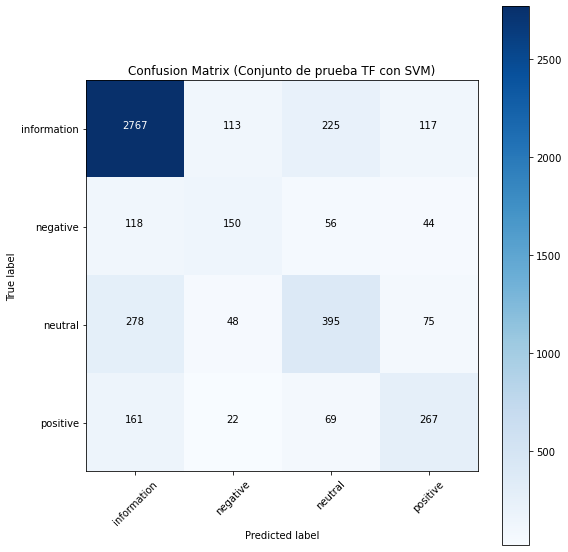

In [52]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_CP_gold, new_predict, labels=['information', 'negative', 'neutral', 'positive'])

plot_CP_confusion_matrix(cm, "Confusion Matrix (Conjunto de prueba TF con SVM)")

#### En las siguientes celdas entrenaremos el modelo usando $TF-IDF$

In [53]:
tfidfvec = TfidfVectorizer(stop_words=stopwords.words('spanish'))  
X_CP_vec = tfidfvec.fit_transform(X_CP)

In [54]:
from sklearn.svm import LinearSVC
svc_CP = LinearSVC(random_state=0, max_iter=3000)
svc_CP.fit(X_CP_vec, Y_CP)

LinearSVC(max_iter=3000, random_state=0)

Ahora evaluaremos el modelo

In [55]:
X_CP_vec = tfidfvec.transform(X_CP)
svc_CP_predict = svc_CP.predict(X_CP_vec)

Aquí obtendremos las métricas de desempeño sobre el conjunto de entrenamiento

In [56]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("TRAIN - Accuracy SVM =", accuracy_score(Y_CP, svc_CP_predict))

print("TRAIN - F1 SVM =", f1_score(Y_CP, svc_CP_predict, average='macro'))
print("TRAIN - micro F1 SVM =", f1_score(Y_CP, svc_CP_predict, average='micro'))

print("TRAIN - Precision SVM =", precision_score(Y_CP, svc_CP_predict, average='macro'))
print("TRAIN - micro Precision SVM =", precision_score(Y_CP, svc_CP_predict, average='micro'))

print("TRAIN - Recall SVM =", recall_score(Y_CP, svc_CP_predict, average='macro'))
print("TRAIN - micro Recall SVM =", recall_score(Y_CP, svc_CP_predict, average='micro'))

dfTabla.at['Accuracy', 'CellPhone_Train_TFIDF_SVM'] = accuracy_score(Y_CP, svc_CP_predict)
dfTabla.at['macro F1', 'CellPhone_Train_TFIDF_SVM'] = f1_score(Y_CP, svc_CP_predict, average='macro')
dfTabla.at['micro F1', 'CellPhone_Train_TFIDF_SVM'] = f1_score(Y_CP, svc_CP_predict, average='micro')
dfTabla.at['macro Precision', 'CellPhone_Train_TFIDF_SVM'] = precision_score(Y_CP, svc_CP_predict, average='macro')
dfTabla.at['micro Precision', 'CellPhone_Train_TFIDF_SVM'] = precision_score(Y_CP, svc_CP_predict, average='micro')
dfTabla.at['macro Recall', 'CellPhone_Train_TFIDF_SVM'] = recall_score(Y_CP, svc_CP_predict, average='macro')
dfTabla.at['micro Recall', 'CellPhone_Train_TFIDF_SVM'] = recall_score(Y_CP, svc_CP_predict, average='micro')

TRAIN - Accuracy SVM = 0.9667948269835722
TRAIN - F1 SVM = 0.9518826035684025
TRAIN - micro F1 SVM = 0.9667948269835722
TRAIN - Precision SVM = 0.9640134379897001
TRAIN - micro Precision SVM = 0.9667948269835722
TRAIN - Recall SVM = 0.9404160902585215
TRAIN - micro Recall SVM = 0.9667948269835722


Para mejor visualización, se anexa la gráfica de la matríz de confunsión.

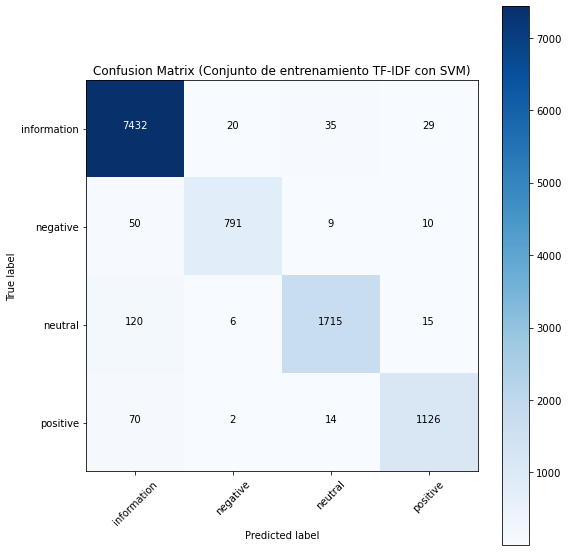

In [57]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_CP, svc_CP_predict, labels=['information', 'negative', 'neutral', 'positive'])

plot_CP_confusion_matrix(cm, "Confusion Matrix (Conjunto de entrenamiento TF-IDF con SVM)")

Vamos a hacer las predicciones con el modelo entrenado y las gráficas de conteos

In [58]:
X_new_vec = tfidfvec.transform(X_CP_gold)
new_predict = svc_CP.predict(X_new_vec)

In [59]:
X_pred = pd.DataFrame(list(zip(X_CP_gold, new_predict)), columns=['text', 'klass'])
X_pred.groupby(['klass']).size()

klass
information    3505
negative        286
neutral         691
positive        423
dtype: int64

In [60]:
print("TEST - Accuracy SVM =", accuracy_score(Y_CP_gold, new_predict))

print("TEST - F1 SVM =", f1_score(Y_CP_gold, new_predict, average='macro'))
print("TEST - micro F1 SVM =", f1_score(Y_CP_gold, new_predict, average='micro'))

print("TEST - Precision SVM =", precision_score(Y_CP_gold, new_predict, average='macro'))
print("TEST - micro Precision SVM =", precision_score(Y_CP_gold, new_predict, average='micro'))

print("TEST - Recall SVM =", recall_score(Y_CP_gold, new_predict, average='macro'))
print("TEST - micro Recall SVM =", recall_score(Y_CP_gold, new_predict, average='micro'))

dfTabla.at['Accuracy', 'CellPhone_Test_TFIDF_SVM'] = accuracy_score(Y_CP_gold, new_predict)
dfTabla.at['macro F1', 'CellPhone_Test_TFIDF_SVM'] = f1_score(Y_CP_gold, new_predict, average='macro')
dfTabla.at['micro F1', 'CellPhone_Test_TFIDF_SVM'] = f1_score(Y_CP_gold, new_predict, average='micro')
dfTabla.at['macro Precision', 'CellPhone_Test_TFIDF_SVM'] = precision_score(Y_CP_gold, new_predict, average='macro')
dfTabla.at['micro Precision', 'CellPhone_Test_TFIDF_SVM'] = precision_score(Y_CP_gold, new_predict, average='micro')
dfTabla.at['macro Recall', 'CellPhone_Test_TFIDF_SVM'] = recall_score(Y_CP_gold, new_predict, average='macro')
dfTabla.at['micro Recall', 'CellPhone_Test_TFIDF_SVM'] = recall_score(Y_CP_gold, new_predict, average='micro')

TEST - Accuracy SVM = 0.7463812436289501
TEST - F1 SVM = 0.586034129378919
TEST - micro F1 SVM = 0.7463812436289501
TEST - Precision SVM = 0.6179248104196231
TEST - micro Precision SVM = 0.7463812436289501
TEST - Recall SVM = 0.5624595927910299
TEST - micro Recall SVM = 0.7463812436289501


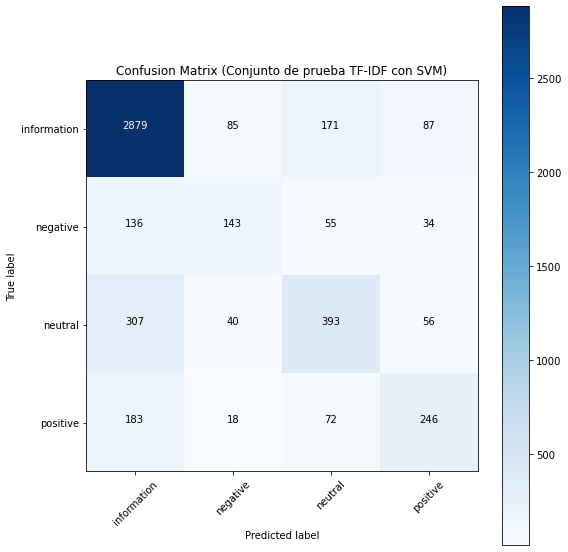

In [61]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_CP_gold, new_predict, labels=['information', 'negative', 'neutral', 'positive'])

plot_CP_confusion_matrix(cm, "Confusion Matrix (Conjunto de prueba TF-IDF con SVM)")

### Entrenamiento de modelos - Modelos SVM para detección de agresividad

#### En las siguientes celdas entrenaremos el modelo usando $TF$

In [62]:
vectorizer = CountVectorizer(stop_words=stopwords.words('spanish'))  
X_AD_vec = vectorizer.fit_transform(X_AD)

In [63]:
from sklearn.svm import LinearSVC
svc_AD = LinearSVC(random_state=0, max_iter=3000)
svc_AD.fit(X_AD_vec, Y_AD)

LinearSVC(max_iter=3000, random_state=0)

Ahora evaluaremos el modelo

In [64]:
X_AD_vec = vectorizer.transform(X_AD)
svc_AD_predict = svc_AD.predict(X_AD_vec)

Aquí obtendremos las métricas de desempeño sobre el conjunto de entrenamiento

In [65]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("TRAIN - Accuracy SVM =", accuracy_score(Y_AD, svc_AD_predict))

print("TRAIN - F1 SVM =", f1_score(Y_AD, svc_AD_predict, average='macro'))
print("TRAIN - micro F1 SVM =", f1_score(Y_AD, svc_AD_predict, average='micro'))

print("TRAIN - Precision SVM =", precision_score(Y_AD, svc_AD_predict, average='macro'))
print("TRAIN - micro Precision SVM =", precision_score(Y_AD, svc_AD_predict, average='micro'))

print("TRAIN - Recall SVM =", recall_score(Y_AD, svc_AD_predict, average='macro'))
print("TRAIN - micro Recall SVM =", recall_score(Y_AD, svc_AD_predict, average='micro'))

dfTabla.at['Accuracy', 'Aggressiveness_Train_TF_SVM'] = accuracy_score(Y_AD, svc_AD_predict)
dfTabla.at['macro F1', 'Aggressiveness_Train_TF_SVM'] = f1_score(Y_AD, svc_AD_predict, average='macro')
dfTabla.at['micro F1', 'Aggressiveness_Train_TF_SVM'] = f1_score(Y_AD, svc_AD_predict, average='micro')
dfTabla.at['macro Precision', 'Aggressiveness_Train_TF_SVM'] = precision_score(Y_AD, svc_AD_predict, average='macro')
dfTabla.at['micro Precision', 'Aggressiveness_Train_TF_SVM'] = precision_score(Y_AD, svc_AD_predict, average='micro')
dfTabla.at['macro Recall', 'Aggressiveness_Train_TF_SVM'] = recall_score(Y_AD, svc_AD_predict, average='macro')
dfTabla.at['micro Recall', 'Aggressiveness_Train_TF_SVM'] = recall_score(Y_AD, svc_AD_predict, average='micro')

TRAIN - Accuracy SVM = 0.995128604832424
TRAIN - F1 SVM = 0.9940452163477794
TRAIN - micro F1 SVM = 0.995128604832424
TRAIN - Precision SVM = 0.995157559342924
TRAIN - micro Precision SVM = 0.995128604832424
TRAIN - Recall SVM = 0.9929489750270217
TRAIN - micro Recall SVM = 0.995128604832424


Para mejor visualización, se anexa la gráfica de la matríz de confunsión.

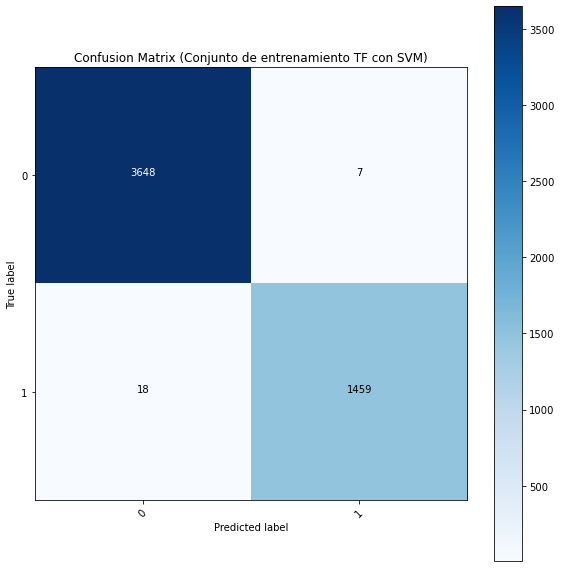

In [66]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_AD, svc_AD_predict, labels=[0, 1])

plot_AD_confusion_matrix(cm, "Confusion Matrix (Conjunto de entrenamiento TF con SVM)")

Vamos a hacer las predicciones con el modelo entrenado y las gráficas de conteos

In [67]:
X_new_vec = vectorizer.transform(X_AD_gold)
new_predict = svc_AD.predict(X_new_vec)

In [68]:
X_pred = pd.DataFrame(list(zip(X_AD_gold, new_predict)), columns=['text', 'klass'])
X_pred.groupby(['klass']).size()

klass
0    1642
1     554
dtype: int64

In [69]:
print("TEST - Accuracy SVM =", accuracy_score(Y_AD_gold, new_predict))

print("TEST - F1 SVM =", f1_score(Y_AD_gold, new_predict, average='macro'))
print("TEST - micro F1 SVM =", f1_score(Y_AD_gold, new_predict, average='micro'))

print("TEST - Precision SVM =", precision_score(Y_AD_gold, new_predict, average='macro'))
print("TEST - micro Precision SVM =", precision_score(Y_AD_gold, new_predict, average='micro'))

print("TEST - Recall SVM =", recall_score(Y_AD_gold, new_predict, average='macro'))
print("TEST - micro Recall SVM =", recall_score(Y_AD_gold, new_predict, average='micro'))

dfTabla.at['Accuracy', 'Aggressiveness_Test_TF_SVM'] = accuracy_score(Y_AD_gold, new_predict)
dfTabla.at['macro F1', 'Aggressiveness_Test_TF_SVM'] = f1_score(Y_AD_gold, new_predict, average='macro')
dfTabla.at['micro F1', 'Aggressiveness_Test_TF_SVM'] = f1_score(Y_AD_gold, new_predict, average='micro')
dfTabla.at['macro Precision', 'Aggressiveness_Test_TF_SVM'] = precision_score(Y_AD_gold, new_predict, average='macro')
dfTabla.at['micro Precision', 'Aggressiveness_Test_TF_SVM'] = precision_score(Y_AD_gold, new_predict, average='micro')
dfTabla.at['macro Recall', 'Aggressiveness_Test_TF_SVM'] = recall_score(Y_AD_gold, new_predict, average='macro')
dfTabla.at['micro Recall', 'Aggressiveness_Test_TF_SVM'] = recall_score(Y_AD_gold, new_predict, average='micro')

TEST - Accuracy SVM = 0.7946265938069217
TEST - F1 SVM = 0.7393897052728802
TEST - micro F1 SVM = 0.7946265938069217
TEST - Precision SVM = 0.7508376682481961
TEST - micro Precision SVM = 0.7946265938069217
TEST - Recall SVM = 0.7310638319417933
TEST - micro Recall SVM = 0.7946265938069217


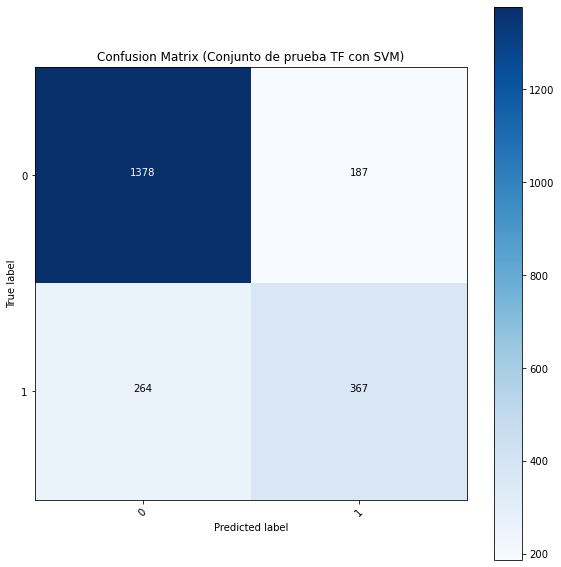

In [70]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_AD_gold, new_predict, labels=[0, 1])

plot_AD_confusion_matrix(cm, "Confusion Matrix (Conjunto de prueba TF con SVM)")

#### En las siguientes celdas entrenaremos el modelo usando $TF-IDF$

In [71]:
tfidfvec = TfidfVectorizer(stop_words=stopwords.words('spanish'))  
X_AD_vec = tfidfvec.fit_transform(X_AD)

In [72]:
from sklearn.svm import LinearSVC
svc_AD = LinearSVC(random_state=0, max_iter=3000)
svc_AD.fit(X_AD_vec, Y_AD)

LinearSVC(max_iter=3000, random_state=0)

Ahora evaluaremos el modelo

In [73]:
X_AD_vec = tfidfvec.transform(X_AD)
svc_AD_predict = svc_AD.predict(X_AD_vec)

Aquí obtendremos las métricas de desempeño sobre el conjunto de entrenamiento

In [74]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("TRAIN - Accuracy SVM =", accuracy_score(Y_AD, svc_AD_predict))

print("TRAIN - F1 SVM =", f1_score(Y_AD, svc_AD_predict, average='macro'))
print("TRAIN - micro F1 SVM =", f1_score(Y_AD, svc_AD_predict, average='micro'))

print("TRAIN - Precision SVM =", precision_score(Y_AD, svc_AD_predict, average='macro'))
print("TRAIN - micro Precision SVM =", precision_score(Y_AD, svc_AD_predict, average='micro'))

print("TRAIN - Recall SVM =", recall_score(Y_AD, svc_AD_predict, average='macro'))
print("TRAIN - micro Recall SVM =", recall_score(Y_AD, svc_AD_predict, average='micro'))

dfTabla.at['Accuracy', 'Aggressiveness_Train_TFIDF_SVM'] = accuracy_score(Y_AD, svc_AD_predict)
dfTabla.at['macro F1', 'Aggressiveness_Train_TFIDF_SVM'] = f1_score(Y_AD, svc_AD_predict, average='macro')
dfTabla.at['micro F1', 'Aggressiveness_Train_TFIDF_SVM'] = f1_score(Y_AD, svc_AD_predict, average='micro')
dfTabla.at['macro Precision', 'Aggressiveness_Train_TFIDF_SVM'] = precision_score(Y_AD, svc_AD_predict, average='macro')
dfTabla.at['micro Precision', 'Aggressiveness_Train_TFIDF_SVM'] = precision_score(Y_AD, svc_AD_predict, average='micro')
dfTabla.at['macro Recall', 'Aggressiveness_Train_TFIDF_SVM'] = recall_score(Y_AD, svc_AD_predict, average='macro')
dfTabla.at['micro Recall', 'Aggressiveness_Train_TFIDF_SVM'] = recall_score(Y_AD, svc_AD_predict, average='micro')

TRAIN - Accuracy SVM = 0.9809041309431021
TRAIN - F1 SVM = 0.9764887022954434
TRAIN - micro F1 SVM = 0.9809041309431021
TRAIN - Precision SVM = 0.9811883429620605
TRAIN - micro Precision SVM = 0.9809041309431021
TRAIN - Recall SVM = 0.9720694979193044
TRAIN - micro Recall SVM = 0.9809041309431021


Para mejor visualización, se anexa la gráfica de la matríz de confunsión.

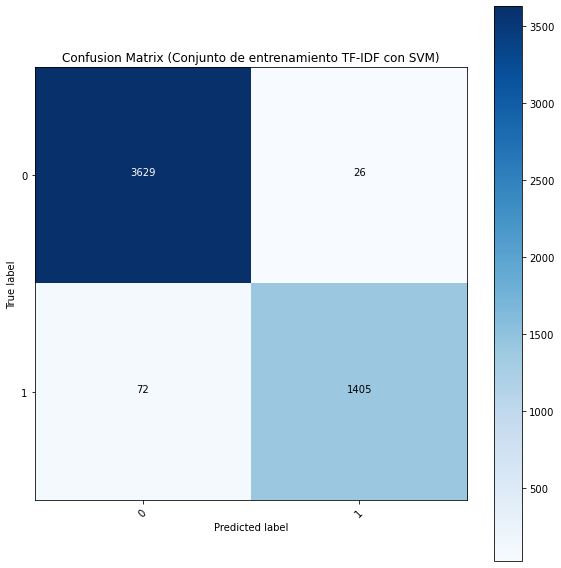

In [75]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_AD, svc_AD_predict, labels=[0, 1])

plot_AD_confusion_matrix(cm, "Confusion Matrix (Conjunto de entrenamiento TF-IDF con SVM)")

Vamos a hacer las predicciones con el modelo entrenado y las gráficas de conteos

In [76]:
X_new_vec = tfidfvec.transform(X_AD_gold)
new_predict = svc_AD.predict(X_new_vec)

In [77]:
X_pred = pd.DataFrame(list(zip(X_AD_gold, new_predict)), columns=['text', 'klass'])
X_pred.groupby(['klass']).size()

klass
0    1662
1     534
dtype: int64

In [78]:
print("TEST - Accuracy SVM =", accuracy_score(Y_AD_gold, new_predict))

print("TEST - F1 SVM =", f1_score(Y_AD_gold, new_predict, average='macro'))
print("TEST - micro F1 SVM =", f1_score(Y_AD_gold, new_predict, average='micro'))

print("TEST - Precision SVM =", precision_score(Y_AD_gold, new_predict, average='macro'))
print("TEST - micro Precision SVM =", precision_score(Y_AD_gold, new_predict, average='micro'))

print("TEST - Recall SVM =", recall_score(Y_AD_gold, new_predict, average='macro'))
print("TEST - micro Recall SVM =", recall_score(Y_AD_gold, new_predict, average='micro'))

dfTabla.at['Accuracy', 'Aggressiveness_Test_TFIDF_SVM'] = accuracy_score(Y_AD_gold, new_predict)
dfTabla.at['macro F1', 'Aggressiveness_Test_TFIDF_SVM'] = f1_score(Y_AD_gold, new_predict, average='macro')
dfTabla.at['micro F1', 'Aggressiveness_Test_TFIDF_SVM'] = f1_score(Y_AD_gold, new_predict, average='micro')
dfTabla.at['macro Precision', 'Aggressiveness_Test_TFIDF_SVM'] = precision_score(Y_AD_gold, new_predict, average='macro')
dfTabla.at['micro Precision', 'Aggressiveness_Test_TFIDF_SVM'] = precision_score(Y_AD_gold, new_predict, average='micro')
dfTabla.at['macro Recall', 'Aggressiveness_Test_TFIDF_SVM'] = recall_score(Y_AD_gold, new_predict, average='macro')
dfTabla.at['micro Recall', 'Aggressiveness_Test_TFIDF_SVM'] = recall_score(Y_AD_gold, new_predict, average='micro')

TEST - Accuracy SVM = 0.813752276867031
TEST - F1 SVM = 0.7610919667877392
TEST - micro F1 SVM = 0.813752276867031
TEST - Precision SVM = 0.7778194675428278
TEST - micro Precision SVM = 0.813752276867031
TEST - Recall SVM = 0.7496843085927809
TEST - micro Recall SVM = 0.813752276867031


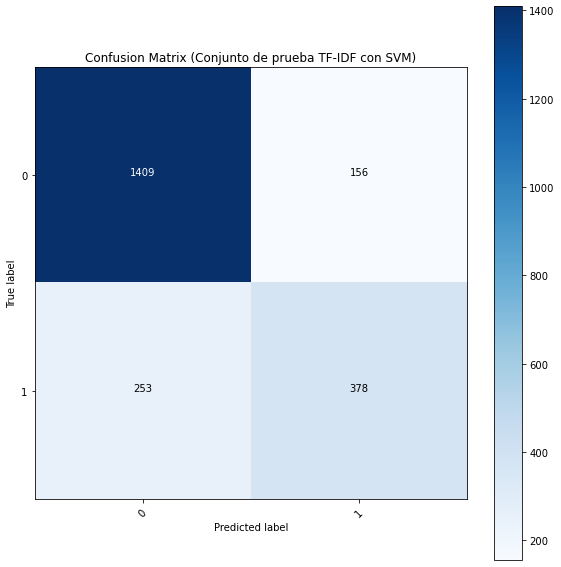

In [79]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_AD_gold, new_predict, labels=[0, 1])

plot_AD_confusion_matrix(cm, "Confusion Matrix (Conjunto de prueba TF-IDF con SVM)")

## Conclusiones

El clasificador basado en SVM lineal tiene el mejor desempeño cuando se usa la vectorización **TF** o **TF-IDF** para ambos conjuntos de datos. De hecho, en el entrenamiento, la mejores métricas fueron resultantes del entrenamiento con SVM. Eso puede comprobarse en la siguiente tabla.

In [80]:
dfTabla[['CellPhone_Train_TF_Naive', 'CellPhone_Train_TFIDF_Naive', 'CellPhone_Train_TF_SVM', 'CellPhone_Train_TFIDF_SVM']]

,CellPhone_Train_TF_Naive,CellPhone_Train_TFIDF_Naive,CellPhone_Train_TF_SVM,CellPhone_Train_TFIDF_SVM
Medida,,,,
Accuracy,0.825236,0.716445,0.984883,0.966795
macro F1,0.702727,0.393971,0.977015,0.951883
micro F1,0.825236,0.716445,0.984883,0.966795
macro Precision,0.839058,0.915222,0.980106,0.964013
micro Precision,0.825236,0.716445,0.984883,0.966795
macro Recall,0.637663,0.362435,0.973995,0.940416
micro Recall,0.825236,0.716445,0.984883,0.966795


El buen comportamiento del clasificador basado en SVM lineal es evidente en las médidas de desempeño para el conjunto de pruebas descritas debajo. Tanto **SVM** con **TF** como con **TF-IDF** nos muestra que en general tienen el mejor desempeño, sin embargo es importante identificar cual es la métrica más importante para el análisis.

In [81]:
dfTabla[['CellPhone_Test_TF_Naive', 'CellPhone_Test_TFIDF_Naive', 'CellPhone_Test_TF_SVM', 'CellPhone_Test_TFIDF_SVM']]

,CellPhone_Test_TF_Naive,CellPhone_Test_TFIDF_Naive,CellPhone_Test_TF_SVM,CellPhone_Test_TFIDF_SVM
Medida,,,,
Accuracy,0.728644,0.707849,0.729664,0.746381
macro F1,0.478235,0.365602,0.577130,0.586034
micro F1,0.728644,0.707849,0.729664,0.746381
macro Precision,0.722006,0.916137,0.585974,0.617925
micro Precision,0.728644,0.707849,0.729664,0.746381
macro Recall,0.430886,0.344622,0.569269,0.562460
micro Recall,0.728644,0.707849,0.729664,0.746381


Para el caso de la identificación de agresividad, el entrenamiento de los modelos dio métricas muy altas para casi todos los experimentos, excepto para el caso del conjunto de pruebas utilizando **TF-IDF** con **naïve**. En el caso de **SVM**, observamos las métricas más altas.

In [82]:
dfTabla[['Aggressiveness_Train_TF_Naive', 'Aggressiveness_Train_TFIDF_Naive', 
         'Aggressiveness_Train_TF_SVM', 'Aggressiveness_Train_TFIDF_SVM']]

,Aggressiveness_Train_TF_Naive,Aggressiveness_Train_TFIDF_Naive,Aggressiveness_Train_TF_SVM,Aggressiveness_Train_TFIDF_SVM
Medida,,,,
Accuracy,0.920499,0.817615,0.995129,0.980904
macro F1,0.898387,0.712834,0.994045,0.976489
micro F1,0.920499,0.817615,0.995129,0.980904
macro Precision,0.921635,0.892208,0.995158,0.981188
micro Precision,0.920499,0.817615,0.995129,0.980904
macro Recall,0.881248,0.684554,0.992949,0.972069
micro Recall,0.920499,0.817615,0.995129,0.980904


El buen comportamiento del clasificador basado en **SVM** lineal con **TF-IDF** así como **naïve** con **TF** es evidente en las médidas de desempeño para el conjunto de pruebas descritas debajo. Sin emnargo, **SVM** con **TF-IDF** nos muestra que en general tienen el mejor desempeño.

In [83]:
dfTabla[['Aggressiveness_Test_TF_Naive', 'Aggressiveness_Test_TFIDF_Naive', 
         'Aggressiveness_Test_TF_SVM', 'Aggressiveness_Test_TFIDF_SVM']]

,Aggressiveness_Test_TF_Naive,Aggressiveness_Test_TFIDF_Naive,Aggressiveness_Test_TF_SVM,Aggressiveness_Test_TFIDF_SVM
Medida,,,,
Accuracy,0.816940,0.748179,0.794627,0.813752
macro F1,0.752271,0.543218,0.739390,0.761092
micro F1,0.816940,0.748179,0.794627,0.813752
macro Precision,0.795091,0.827808,0.750838,0.777819
micro Precision,0.816940,0.748179,0.794627,0.813752
macro Recall,0.732059,0.565590,0.731064,0.749684
micro Recall,0.816940,0.748179,0.794627,0.813752
